In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Grid Search

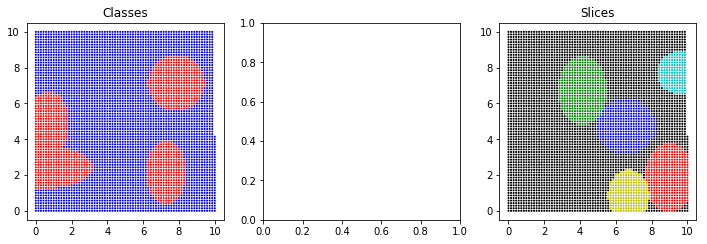

In [2]:
from torch.utils.data import DataLoader

from metal.utils import SlicingDataset
from metal.contrib.slicing.synthetics.geometric_synthetics import generate_dataset
from metal.utils import split_data

NUM_TRIALS = 20
NUM_SLICES = 5
K = 2
M = 20
N = 5000
unipolar = True
seed = None

Z_kwargs = {'num_slices': NUM_SLICES}
L, X, Y, Z, _ = generate_dataset(K, M, N, 
                                 Z_kwargs=Z_kwargs,
                                 unipolar=unipolar,
                                 seed=seed)

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

In [3]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
snorkel_model = SnorkelLabelModel()
snorkel_model.train_model(Ls[0])
snorkel_model.score((Ls[1], Ys[1]))

Y_train = snorkel_model.predict_proba(Ls[0])
Ys[0] = Y_train

# TEMP
from metal.contrib.slicing.utils import add_pepper
pepper = 0.1
Ls[0] = add_pepper(Ls[0], pepper)

snorkel_model.train_model(Ls[0])
snorkel_model.score((Ls[1], Ys[1]))

Accuracy: 0.686
        y=1    y=2   
 l=1    158    222   
 l=2    170    700   


0.6864

/Users/bradenjh/anaconda3/envs/metal/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Added pepper=0.1 random negatives on 20/20 LFs
Accuracy: 0.695
        y=1    y=2   
 l=1    169    222   
 l=2    159    700   


0.6952

In [ ]:
layer_out_dims = [2, 10, 10, 2]
search_space = {
    'n_epochs': [20],
    'lr': [0.01],
    'l2': [1e-7], #{'range': [1e-7, 1e-3], 'scale': 'log'},
    'slice_weight': [0.1],
    # 'batch_size': None <-- This is handled in DataLoader
}

In [ ]:
import torch
from torch.utils.data import DataLoader

from metal.tuners import RandomSearchTuner
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.utils import SlicingDataset
from metal.end_model import EndModel

batch_size = 32
L_train = torch.Tensor(Ls[0].todense())
train_dataset = SlicingDataset(Xs[0], L_train, Ys[0])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
end_model = EndModel(layer_out_dims, verbose=False)

tuner = RandomSearchTuner(SliceHatModel, log_dir='checkpoints')
best_model = tuner.search(
    search_space,
    valid_data=(Xs[1], Ys[1]),
    max_search=10,
    init_args=[end_model, M],
    init_kwargs={'verbose': False},
    train_args=[train_loader],
    train_kwargs={'verbose': True, 'disable_prog_bar': True, 'print_every': 5},
    verbose=True,
)

In [ ]:
from metal.contrib.slicing.experiment_utils import eval_model
from metal.contrib.slicing.experiment_utils import parse_history

test_dataset = SlicingDataset(Xs[2], Ys[2], Zs[2])
test_loader = DataLoader(test_dataset)

results = eval_model(best_model, test_loader, verbose=False)
history = {'sm': [results]}
df = parse_history(history, NUM_SLICES)
df

## Scratch